# Text classification case study

## Dataset 20 Newsgroups

In [1]:
%matplotlib notebook

In [2]:
import sys
sys.path.append('..')
import warnings
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np
from numba import NumbaDeprecationWarning, NumbaWarning
from numpy.random import RandomState
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from src import runner_
from src.datasets.utils import load_newsgroups
from src.ml.utils import reduce_dimensions_sparse
from src.plotting.utils import visualize_scores, print_results, visualize_classes
from src.problemgenerator.array import Array
from src.problemgenerator.copy import Copy
from src.problemgenerator.filters import MissingArea
from src.problemgenerator.radius_generators import GaussianRadiusGenerator

warnings.simplefilter("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaWarning)

In [3]:
class ErrGen:
    def __init__(self):
        self.random_state = RandomState(42)

    def generate_error(self, data, params):
        data_node = Array(data.shape)
        root_node = Copy(data_node)

        f = MissingArea(params["p"], params["radius_generator"], params["missing_value"])
        data_node.addfilter(f)

        return root_node.process(data, self.random_state)

In [4]:
class Preprocessor:
    def __init__(self):
        self.random_state = RandomState(42)

    def run(self, train_data, test_data):
        vectorizer = TfidfVectorizer(max_df=0.5, min_df=2, stop_words="english")
        vectorized_train_data = vectorizer.fit_transform(train_data)
        vectorized_test_data = vectorizer.transform(test_data)

        reduced_test_data = reduce_dimensions_sparse(vectorized_test_data, self.random_state)

        return vectorized_train_data, vectorized_test_data, {"reduced_test_data": reduced_test_data}


In [5]:
class AbstractModel(ABC):

    def __init__(self):
        self.random_state = RandomState(42)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        predicted_test_labels = fitted_model.predict(test_data)
        cm = confusion_matrix(test_labels, predicted_test_labels)

        return {
            "confusion_matrix": cm,
            "predicted_test_labels": predicted_test_labels,
            "test_mean_accuracy": round(np.mean(predicted_test_labels == test_labels), 3),
            "train_mean_accuracy": fitted_model.score(train_data, train_labels),
        }


In [6]:
class MultinomialNBModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return MultinomialNB(params["alpha"]).fit(train_data, train_labels)



In [7]:
class LinearSVCModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return LinearSVC(C=params["C"], random_state=self.random_state).fit(train_data, train_labels)


In [8]:
def visualize(df, dataset_name, label_names, test_data):
    visualize_scores(df, ["test_mean_accuracy", "train_mean_accuracy"], "p",
                     f"{dataset_name} classification scores with added missing areas")
    visualize_classes(df, label_names, "p", "reduced_test_data", "test_labels", "tab20",
                      f"{dataset_name} (n={len(test_data)}) classes with added missing areas")

    def on_click(element, label, predicted_label):
        print(label, " predicted as ", predicted_label, ":", sep="")
        print(element, end="\n\n")

    # Remember to enable runner's interactive mode
    # visualize_confusion_matrices(df, label_names, "test_mean_accuracy", "p", on_click)

    plt.show()

In [9]:
def main(argv):
    if len(argv) == 3 and argv[1] in ["all", "test"]:
        data, labels, label_names, dataset_name = load_newsgroups(argv[1], int(argv[2]))
    else:
        exit(0)

    train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.2,
                                                                        random_state=RandomState(42))

    p_steps = np.linspace(0, .28, num=8)
    err_params_list = [{
        "p": p,
        "radius_generator": GaussianRadiusGenerator(0, 1),
        "missing_value": " "
    } for p in p_steps]

    alpha_steps = [10 ** i for i in range(-2, 1)]
    C_steps = [10 ** k for k in range(-2, 1)]
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    model_params_dict_list = [
        {
            "model": MultinomialNBModel,
            "params_list": [{"alpha": alpha, **model_params_base} for alpha in alpha_steps],
            "use_clean_train_data": False
        },
        {
            "model": MultinomialNBModel,
            "params_list": [{"alpha": alpha, **model_params_base} for alpha in alpha_steps],
            "use_clean_train_data": True
        },
        {
            "model": LinearSVCModel,
            "params_list": [{"C": C, **model_params_base} for C in C_steps],
            "use_clean_train_data": False
        },
        {
            "model": LinearSVCModel,
            "params_list": [{"C": C, **model_params_base} for C in C_steps],
            "use_clean_train_data": True
        },
    ]

    df = runner_.run(train_data, test_data, Preprocessor, ErrGen, err_params_list, model_params_dict_list, False)

    print_results(df, ["train_labels", "test_labels", "reduced_test_data", "confusion_matrix", "predicted_test_labels",
                       "radius_generator", "missing_value"])
    visualize(df, dataset_name, label_names, test_data)


100%|██████████| 8/8 [01:26<00:00,  9.54s/it]

LinearSVC
       C     p  test_mean_accuracy  time_used_err  time_used_mod  time_used_preproc  train_mean_accuracy
0   0.01  0.00               0.768       1.525244       0.106326          16.905520             0.868797
1   0.10  0.00               0.808       1.525244       0.148246          16.905520             0.948674
2   1.00  0.00               0.803       1.525244       0.243515          16.905520             0.973487
3   0.01  0.04               0.688      11.921290       0.106810          18.212409             0.861319
4   0.10  0.04               0.751      11.921290       0.158461          18.212409             0.957172
5   1.00  0.04               0.742      11.921290       0.284298          18.212409             0.973827
6   0.01  0.08               0.624      18.331189       0.102409          17.903948             0.843304
7   0.10  0.08               0.673      18.331189       0.150421          17.903948             0.959211
8   1.00  0.08               0.663      18.33

<IPython.core.display.Javascript object>


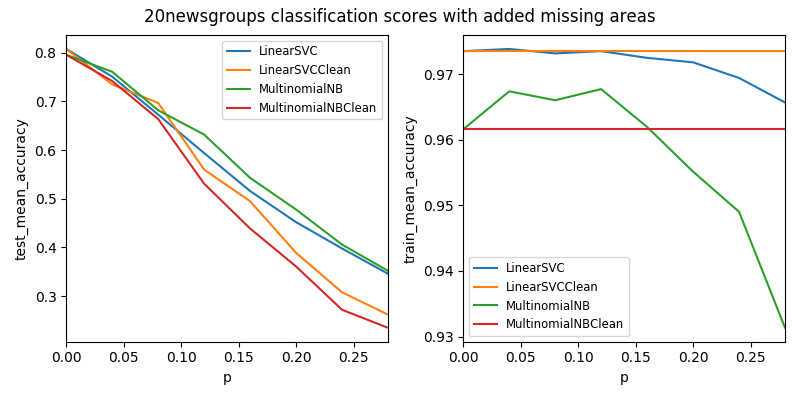

<IPython.core.display.Javascript object>


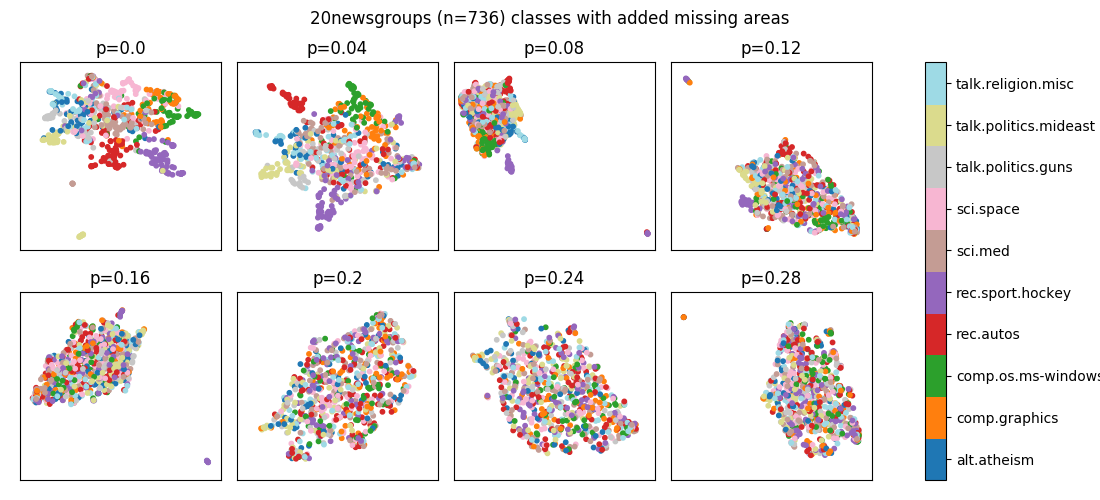

In [10]:
main(["x", "test", "10"])